In [1]:
import numpy as np
import matplotlib.pyplot as plt
from copy import copy
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import shapely.geometry as sgeom
import metpy.calc as mpcalc
import salem as sl
import wrf
from netCDF4 import Dataset
plt.rcParams['font.sans-serif'] = ['SimHei']  ###防止无法显示中文并设置黑体
plt.rcParams['axes.unicode_minus'] = False  ###用来正常显示负号

In [2]:
# colormap设置
def createCmap(rgbfile,name='example',n=1):
    import numpy as np 
    from matplotlib.colors import ListedColormap
    with open(rgbfile,'r') as f:
        ca=f.readlines()
    for j,i in enumerate(ca) :
        pan=('r' in i,'g' in i,'b' in i)
        if all(pan):
            skiprows=j+1
    colors=np.loadtxt(rgbfile,skiprows=skiprows,dtype=np.int64)
    if n==1:
        n=len(colors)
    colorlist=[]
    for i in range(len(colors)):
        colorlist.append(tuple(colors[i,:]/256))
    cm = ListedColormap(
        colorlist,  
        name=name,
        N = n)
    return cm
# 创建地图
def find_side(ls, side):
    """
    Given a shapely LineString which is assumed to be rectangular, return the
    line corresponding to a given side of the rectangle.
    """
    # print(ls.bounds)
    minx, miny, maxx, maxy = ls.bounds
    points = {'left': [(minx, miny), (minx, maxy)],
              'right': [(maxx, miny), (maxx, maxy)],
              'bottom': [(minx, miny), (maxx, miny)],
              'top': [(minx, maxy), (maxx, maxy)],}
    return sgeom.LineString(points[side])

def lambert_xticks(ax, ticks):
    """Draw ticks on the bottom x-axis of a Lambert Conformal projection."""
    te = lambda xy: xy[0]
    lc = lambda t, n, b: np.vstack((np.zeros(n) + t, np.linspace(b[2], b[3], n))).T
    xticks, xticklabels = _lambert_ticks(ax, ticks, 'bottom', lc, te)
    ax.xaxis.tick_bottom()
    ax.set_xticks(xticks)
    ax.set_xticklabels([ax.xaxis.get_major_formatter()(xtick) for xtick in xticklabels])

def lambert_yticks(ax, ticks):
    """Draw ricks on the left y-axis of a Lamber Conformal projection."""
    te = lambda xy: xy[1]
    lc = lambda t, n, b: np.vstack((np.linspace(b[0], b[1], n), np.zeros(n) + t)).T
    print(lc)
    yticks, yticklabels = _lambert_ticks(ax, ticks, 'left', lc, te)
    ax.yaxis.tick_left()
    ax.set_yticks(yticks)
    ax.set_yticklabels([ax.yaxis.get_major_formatter()(ytick) for ytick in yticklabels])

def _lambert_ticks(ax, ticks, tick_location, line_constructor, tick_extractor):
    """Get the tick locations and labels for an axis of a Lambert Conformal projection."""
    # outline_patch = sgeom.LineString(ax.outline_patch.get_path().vertices.tolist())
    outline_patch = sgeom.LineString(ax.spines['geo'].get_path().vertices.tolist())
    axis = find_side(outline_patch, tick_location)
    n_steps = 30
    extent = ax.get_extent(ccrs.PlateCarree())
    _ticks = []
    for t in ticks:
        xy = line_constructor(t, n_steps, extent)
        proj_xyz = ax.projection.transform_points(ccrs.Geodetic(), xy[:, 0], xy[:, 1])
        xyt = proj_xyz[..., :2]
        ls = sgeom.LineString(xyt.tolist())
        locs = axis.intersection(ls)
        if not locs:
            tick = [None]
        else:
            tick = tick_extractor(locs.xy)
        _ticks.append(tick[0])
    # Remove ticks that aren't visible:
    ticklabels = copy(ticks)
    while True:
        try:
            index = _ticks.index(None)
        except ValueError:
            break
        _ticks.pop(index)
        ticklabels.pop(index)
    return _ticks, ticklabels

def createmap():
    box1 = [110.00,123.5,22.07,36.68]
    fig=plt.figure(figsize=(7,6))
    ax=fig.subplots(1,1,subplot_kw={'projection':ccrs.LambertConformal(central_longitude=138)})
    # ax.coastlines('50m')
    ax.add_geometries(Reader('D:\\maplist\\China_province\\bou2_4l.shp').geometries(), ccrs.PlateCarree(),
                facecolor='none', edgecolor='gray', linewidth=0.8)
    ax.set_extent(box1, crs=ccrs.PlateCarree())
    ##############
    fig.canvas.draw()  # 必要的
    ##############
    # 坐标刻度的绘制
    xticks = [103,110,116,120,124,126]
    yticks = [22,26,30,34]
    ax.gridlines(xlocs=xticks, ylocs=yticks, linestyle=':', linewidth=0.3, x_inline=False, y_inline=False, color='k')
    ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER)
    ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
    lambert_xticks(ax, xticks)
    lambert_yticks(ax, yticks)
    return ax,fig

In [3]:
ds=sl.open_wrf_dataset('./data/yuanwrfout_d01_2020-07-06_00_00_00')
ds1=sl.open_wrf_dataset('./data/wrfout_d01_2020-07-06_00_00_00')
ds

<xarray.Dataset>
Dimensions:                (south_north: 60, west_east: 73, time: 9,
                            bottom_top: 32, soil_layers: 3, seed_dim: 11)
Coordinates:
    lat                    (south_north, west_east) float32 22.07 ... 36.68
    lon                    (south_north, west_east) float32 126.5 ... 103.0
    xtime                  (time) datetime64[ns] ...
  * time                   (time) datetime64[ns] 2020-07-06 ... 2020-07-07
  * west_east              (west_east) float64 -8.545e+06 ... -6.385e+06
  * south_north            (south_north) float64 8.748e+06 ... 1.052e+07
Dimensions without coordinates: bottom_top, soil_layers, seed_dim
Data variables: (12/215)
    LU_INDEX               (time, south_north, west_east) float32 ...
    ZNU                    (time, bottom_top) float32 ...
    ZNW                    (time, bottom_top) float32 ...
    ZS                     (time, soil_layers) float32 ...
    DZS                    (time, soil_layers) float32 ...
    VAR_SSO                (time, south_north, west_east) float32 ...
    ...                     ...
    PRESSURE               (time, bottom_top, south_north, west_east) float32 ...
    GEOPOTENTIAL           (time, bottom_top, south_north, west_east) float32 ...
    Z                      (time, bottom_top, south_north, west_east) float32 ...
    SLP                    (time, south_north, west_east) float32 ...
    PRCP_NC                (time, south_north, west_east) float32 ...
    PRCP_C                 (time, south_north, west_east) float32 ...
Attributes: (12/133)
    TITLE:                            OUTPUT FROM WRF V4.2.1 MODEL
    START_DATE:                      2020-07-06_00:00:00
    SIMULATION_START_DATE:           2020-07-06_00:00:00
    WEST-EAST_GRID_DIMENSION:        74
    SOUTH-NORTH_GRID_DIMENSION:      61
    BOTTOM-TOP_GRID_DIMENSION:       33
    ...                              ...
    ISICE:                           15
    ISURBAN:                         13
    ISOILWATER:                      14
    HYBRID_OPT:                      2
    ETAC:                            0.2
    pyproj_srs:                      +proj=lcc +lat_0=30.0000076293945 +lon_0...

In [4]:
Uyuan=ds.salem.wrf_plevel('U',500)
U=ds1.salem.wrf_plevel('U',500)
Vyuan=ds.salem.wrf_plevel('V',500)
V=ds1.salem.wrf_plevel('V',500)
Tyuan=ds.salem.wrf_plevel('T',500)
T=ds1.salem.wrf_plevel('T',500)
QVyuan=ds.salem.wrf_plevel('QVAPOR',500)
QV=ds1.salem.wrf_plevel('QVAPOR',500)

In [5]:
lon=T.lon.data 
lat=T.lat.data 

<function lambert_yticks.<locals>.<lambda> at 0x000001FB77F16710>


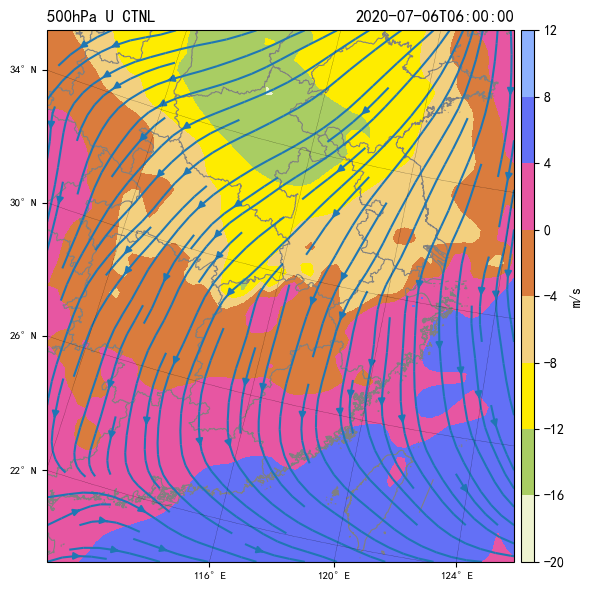

In [6]:
ax,fig=createmap()
colorbar=ax.contourf(lon,lat,Uyuan[2,:,:],cmap=createCmap('./wind_17lev.rgb'),transform=ccrs.PlateCarree())
ax.streamplot(lon,lat,Uyuan[2,:,:].data,Vyuan[2,:,:].data,transform=ccrs.PlateCarree())
cb=plt.colorbar(colorbar,shrink=1,aspect=40,pad=0.01)
cb.set_label("m/s")
ax.set_title('500hPa U CTNL',loc='left')
ax.set_title(Uyuan[2,:,:].time.data.__str__()[:-10],loc='right')
ax.tick_params(labelsize=8)
plt.tight_layout()
plt.savefig('./pic/U_CTNL.png')

<function lambert_yticks.<locals>.<lambda> at 0x000001FB78E8AD40>


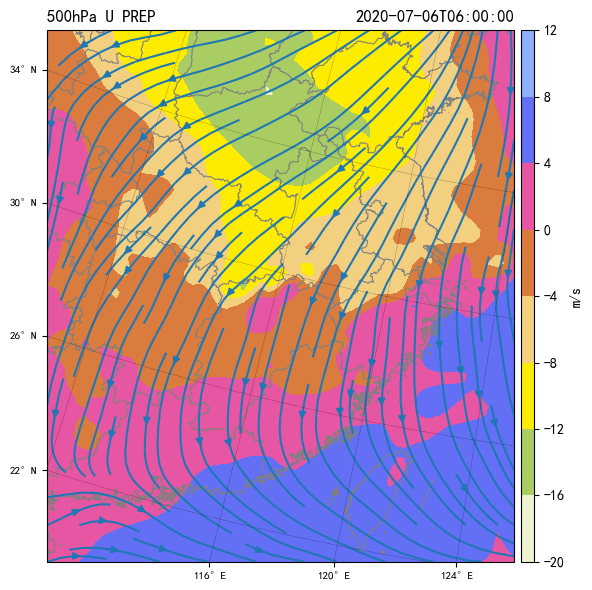

In [7]:
ax,fig=createmap()
colorbar=ax.contourf(lon,lat,U[2,:,:],cmap=createCmap('./wind_17lev.rgb'),transform=ccrs.PlateCarree())
ax.streamplot(lon,lat,Uyuan[2,:,:].data,Vyuan[2,:,:].data,transform=ccrs.PlateCarree())
cb=plt.colorbar(colorbar,shrink=1,aspect=40,pad=0.01)
cb.set_label("m/s")
ax.set_title('500hPa U PREP',loc='left')
ax.set_title(Vyuan[2,:,:].time.data.__str__()[:-10],loc='right')
ax.tick_params(labelsize=8)
plt.tight_layout()
plt.savefig('./pic/U_PREP.png')

<function lambert_yticks.<locals>.<lambda> at 0x000001FB7C089360>


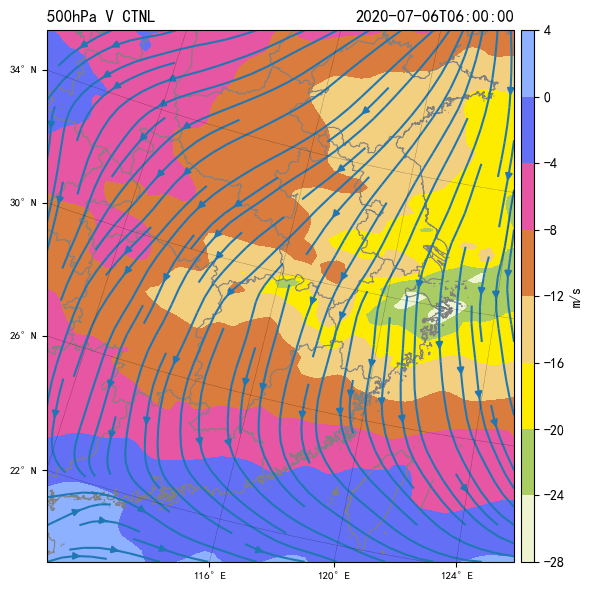

In [8]:
ax,fig=createmap()
colorbar=ax.contourf(lon,lat,Vyuan[2,:,:],cmap=createCmap('./wind_17lev.rgb'),transform=ccrs.PlateCarree())
ax.streamplot(lon,lat,U[2,:,:].data,V[2,:,:].data,transform=ccrs.PlateCarree())
cb=plt.colorbar(colorbar,shrink=1,aspect=40,pad=0.01)
cb.set_label("m/s")
ax.set_title('500hPa V CTNL',loc='left')
ax.set_title(Vyuan[2,:,:].time.data.__str__()[:-10],loc='right')
ax.tick_params(labelsize=8)
plt.tight_layout()
plt.savefig('./pic/V_CTNL.png')

<function lambert_yticks.<locals>.<lambda> at 0x000001FB7C59B010>


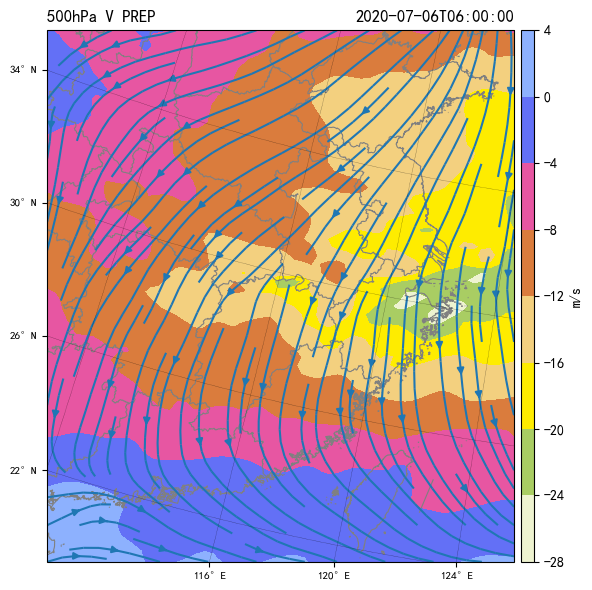

In [9]:
ax,fig=createmap()
colorbar=ax.contourf(lon,lat,V[2,:,:],cmap=createCmap('./wind_17lev.rgb'),transform=ccrs.PlateCarree())
ax.streamplot(lon,lat,U[2,:,:].data,V[2,:,:].data,transform=ccrs.PlateCarree())
cb=plt.colorbar(colorbar,shrink=1,aspect=40,pad=0.01)
cb.set_label("m/s")
ax.set_title('500hPa V PREP',loc='left')
ax.set_title(Vyuan[2,:,:].time.data.__str__()[:-10],loc='right')
ax.tick_params(labelsize=8)
plt.tight_layout()
plt.savefig('./pic/V_PREP.png')

<function lambert_yticks.<locals>.<lambda> at 0x000001FB7DC5CCA0>


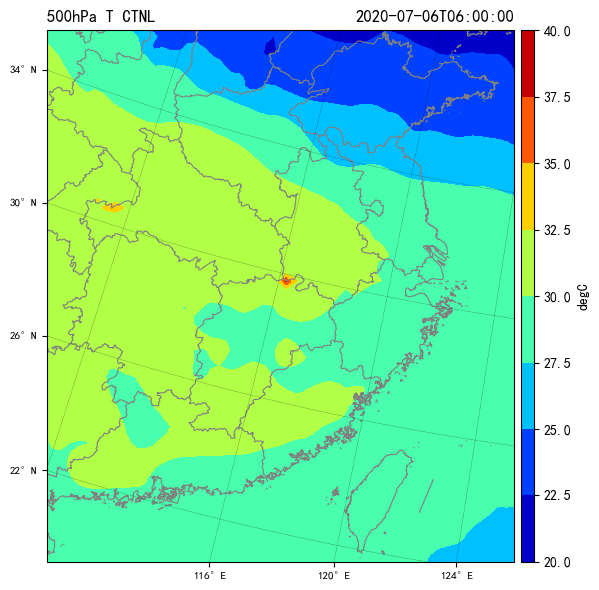

In [10]:
ax,fig=createmap()
colorbar=ax.contourf(lon,lat,Tyuan[2,:,:],cmap='jet',transform=ccrs.PlateCarree())
cb=plt.colorbar(colorbar,shrink=1,aspect=40,pad=0.01)
cb.set_label("degC")
ax.set_title('500hPa T CTNL',loc='left')
ax.set_title(Vyuan[2,:,:].time.data.__str__()[:-10],loc='right')
ax.tick_params(labelsize=8)
plt.tight_layout()
plt.savefig('./pic/T_CTNL.png')

<function lambert_yticks.<locals>.<lambda> at 0x000001FB7DFAC5E0>


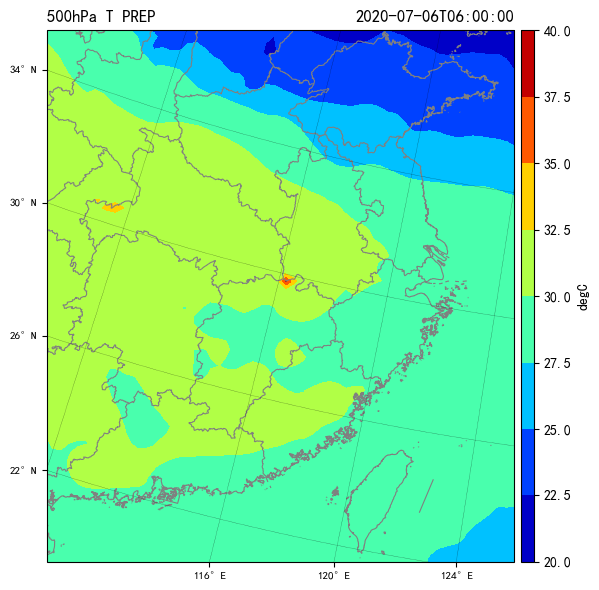

In [11]:
ax,fig=createmap()
colorbar=ax.contourf(lon,lat,T[2,:,:],cmap='jet',transform=ccrs.PlateCarree())
cb=plt.colorbar(colorbar,shrink=1,aspect=40,pad=0.01)
cb.set_label("degC")
ax.set_title('500hPa T PREP',loc='left')
ax.set_title(Vyuan[2,:,:].time.data.__str__()[:-10],loc='right')
ax.tick_params(labelsize=8)
plt.tight_layout()
plt.savefig('./pic/T_PREP.png')

<function lambert_yticks.<locals>.<lambda> at 0x000001FB7DF74CA0>


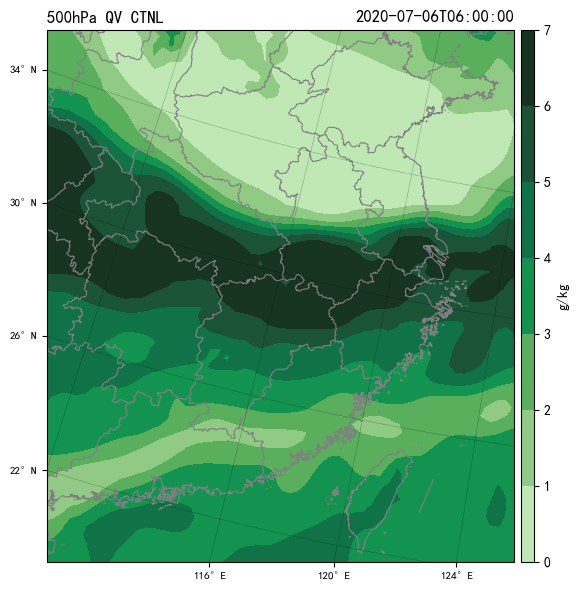

In [12]:
ax,fig=createmap()
colorbar=ax.contourf(lon,lat,QVyuan[2,:,:]*1000,cmap=createCmap('./cmocean_algae.rgb'),transform=ccrs.PlateCarree())
cb=plt.colorbar(colorbar,shrink=1,aspect=40,pad=0.01)
cb.set_label("g/kg")
ax.set_title('500hPa QV CTNL',loc='left')
ax.set_title(Vyuan[2,:,:].time.data.__str__()[:-10],loc='right')
ax.tick_params(labelsize=8)
plt.tight_layout()
plt.savefig('./pic/QV_CTNL.png')

<function lambert_yticks.<locals>.<lambda> at 0x000001FB7C052170>


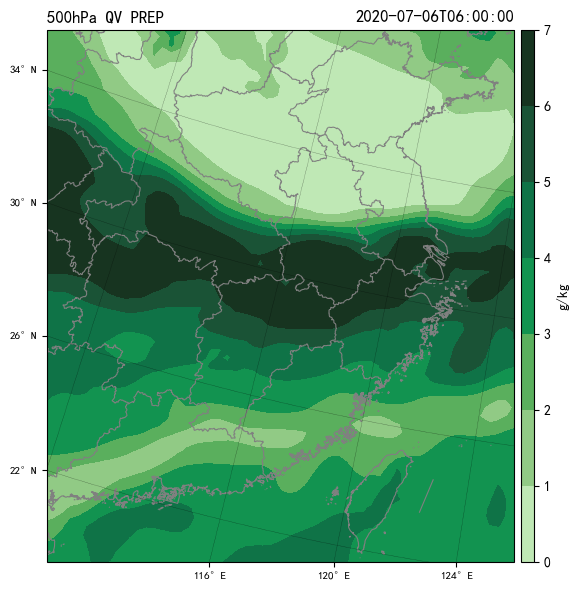

In [13]:
ax,fig=createmap()
colorbar=ax.contourf(lon,lat,QV[2,:,:]*1000,cmap=createCmap('./cmocean_algae.rgb'),transform=ccrs.PlateCarree())
cb=plt.colorbar(colorbar,shrink=1,aspect=40,pad=0.01)
cb.set_label("g/kg")
ax.set_title('500hPa QV PREP',loc='left')
ax.set_title(Vyuan[2,:,:].time.data.__str__()[:-10],loc='right')
ax.tick_params(labelsize=8)
plt.tight_layout()
plt.savefig('./pic/QV_PREP.png')

In [14]:
PRCPyuan=ds['PRCP']
PRCP=ds1['PRCP']

<function lambert_yticks.<locals>.<lambda> at 0x000001FB7DF0AB00>


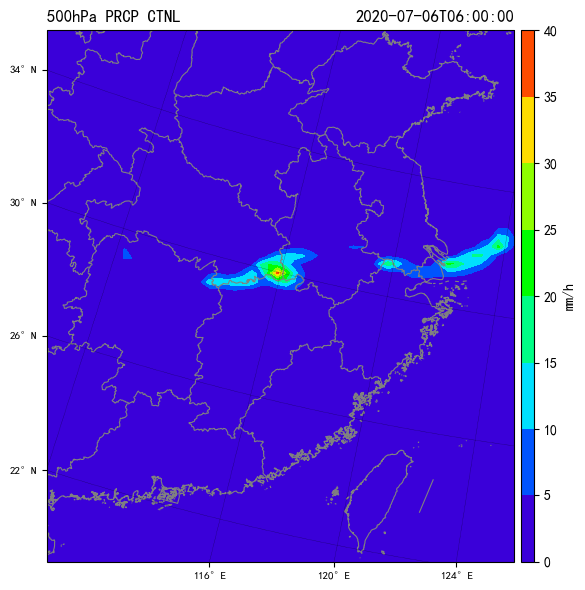

In [15]:
ax,fig=createmap()
colorbar=ax.contourf(lon,lat,PRCPyuan[2,:,:],cmap=createCmap('./rainbow.rgb'),transform=ccrs.PlateCarree())
cb=plt.colorbar(colorbar,shrink=1,aspect=40,pad=0.01)
cb.set_label("mm/h")
ax.set_title('500hPa PRCP CTNL',loc='left')
ax.set_title(Vyuan[2,:,:].time.data.__str__()[:-10],loc='right')
ax.tick_params(labelsize=8)
plt.tight_layout()
plt.savefig('./pic/PRCP_CTNL.png')

<function lambert_yticks.<locals>.<lambda> at 0x000001FB780F6200>


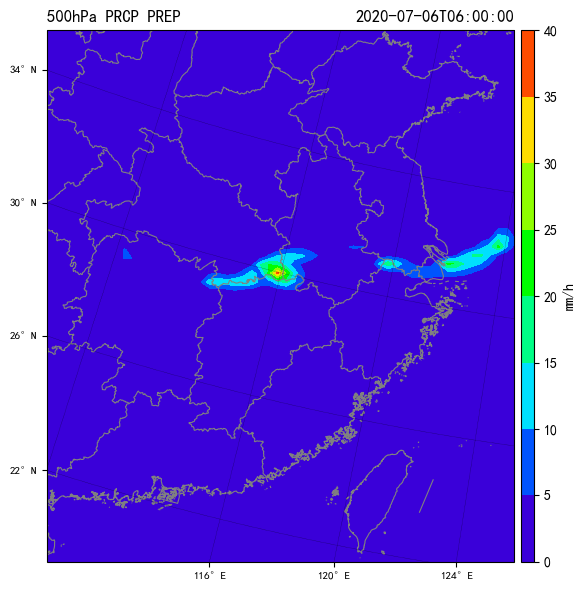

In [16]:
ax,fig=createmap()
colorbar=ax.contourf(lon,lat,PRCP[2,:,:],cmap=createCmap('./rainbow.rgb'),transform=ccrs.PlateCarree())
cb=plt.colorbar(colorbar,shrink=1,aspect=40,pad=0.01)
cb.set_label("mm/h")
ax.set_title('500hPa PRCP PREP',loc='left')
ax.set_title(Vyuan[2,:,:].time.data.__str__()[:-10],loc='right')
ax.tick_params(labelsize=8)
plt.tight_layout()
plt.savefig('./pic/PRCP_PREP.png')